# Get table and use a function to convert to dates
## Example bankruptcies
This weekly StatBank table has a break in the time series from 2010-2018.It is suitable for displaying the date conversion function. Here figures are shown both with the x-axis as categories and as date.

Source: [12972](https://www.ssb.no/en/statbank/table/12972) - Bankruptcies per day

In [2]:
# Import packages 
import requests
import pandas as pd
from pyjstat import pyjstat  # pyjstat is for JSON-stat

URL to table's metadata i PxWebApi, which we are going to post the queries towards

In [3]:
tabid = "12972" # 
lang = "en" # language code can also be "no"
url1 = "https://data.ssb.no/api/v0/" + lang + "/table/" + tabid;

We query for the number of bankruptcies in Norway as a whole, and the number of employees affected per week, for all industries.

In [4]:
query1 = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "item",
        "values": [
          "0N"
        ]
      }
    },
    {
      "code": "Naring",
      "selection": {
        "filter": "item",
        "values": [
          "00-99"
        ]
      }
    },

    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Konkursar"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "all",
        "values": [
          "*"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


General function to identify frequency so that we can convert to date format and set [**Pandas PeriodIndex**](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-span-representation)

In [5]:
def dateConv(dataframe):
    frekvens, frek_no, frek_en, fmt = findFrequency(dataframe)
    setPeriodIndex(frekvens, frek_no, frek_en, fmt, dataframe)

# function to identify frequency    
def findFrequency(dataframe):
    frekvenser = ['måned', 'kvartal', 'uke', 'år', 'year', 'quarter', 'month', 'week']
    frek_no = ''  #statistics Norway unfortunately uses Norwegian and not English frequency codes U - week etc.
    frek_en = '' # English frequency code
    fmt = '' # python date format
    for w in frekvenser:
        if w in dataframe.columns:
            if w in ['måned', 'month']:
                frek_no = 'M'
                frek_en = 'M'
                fmt = '%YM%m'
            elif w in ['kvartal', 'quarter']:
                frek_no = 'K'
                frek_en = 'Q'
            elif w in ['uke', 'week']:
                frek_no = 'U';
                frek_en = 'W'
                fmt = '%YW%W-%w'
            else:
                frek_no = ''
                frek_en = 'A'
            return w, frek_no, frek_en, fmt
    
# function to convert to date format and set the Pandas PeriodIndex.        
def setPeriodIndex(frekvens, frek_no, freq_en, fmt, df):
    if frekvens in ['kvartal', 'quarter']:
        # erstatter K med Q, konverterer til datoformat og setter frekensen til Pandas PeriodIndex. 
        # Pandas forstår engelske frekevenskoder, men SSB bruker norske
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en), errors='coerce'), freq='Q-DEC')
    elif frekvens in ['uke', 'week']:
        # må legge til '-0' for å få ukenr. til å bli mnd-dag
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en).add('-0'), format= fmt, errors='coerce'), freq='W-MON')
    else:
        df.index =  pd.PeriodIndex(pd.to_datetime(df[frekvens], format= fmt, errors='coerce'), freq=freq_en)


Here we post the query

In [6]:
res1 = requests.post(url1, json=query1)

Reads the JSON-stat result using the library [pyjstat](https://pypi.org/project/pyjstat/)

In [7]:
ds1 = pyjstat.Dataset.read(res1.text)

Write the resulting dataset to a Pandas dataframe

In [8]:
df1 = ds1.write('dataframe')

In [9]:
df1.head(3)

,region,industry,contents,week,value
0,The whole country,All industries,Bankruptcies,2009U01,92
1,The whole country,All industries,Bankruptcies,2009U02,86
2,The whole country,All industries,Bankruptcies,2009U03,110


In [10]:
df1.tail(3)

,region,industry,contents,week,value
119,The whole country,All industries,Bankruptcies,2020U22,106
120,The whole country,All industries,Bankruptcies,2020U23,77
121,The whole country,All industries,Bankruptcies,2020U24,2


Set week as index

In [12]:
df1.set_index('week')

,region,industry,contents,value
week,,,,
2009U01,The whole country,All industries,Bankruptcies,92
2009U02,The whole country,All industries,Bankruptcies,86
2009U03,The whole country,All industries,Bankruptcies,110
2009U04,The whole country,All industries,Bankruptcies,11
2009U05,The whole country,All industries,Bankruptcies,15
...,...,...,...,...
2020U20,The whole country,All industries,Bankruptcies,59
2020U21,The whole country,All industries,Bankruptcies,66
2020U22,The whole country,All industries,Bankruptcies,106


In [13]:
df1.index

RangeIndex(start=0, stop=122, step=1)

#### plot the dataframe using Pandas plot

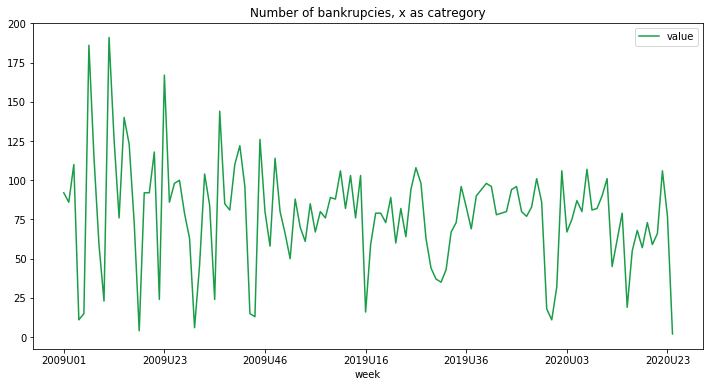

In [16]:
df1.plot(x='week', y='value', figsize=(12, 6), color='#1a9d49', title="Number of bankruptcies, x as catregory")

Calls the dateConv function that converts from category to date format. This is then set as an index using Pandas PeriodIndex.

In [17]:
dateConv(df1)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Now we have a PeriodIndex

In [18]:
df1.index

PeriodIndex(['2009-01-06/2009-01-12', '2009-01-13/2009-01-19',
             '2009-01-20/2009-01-26', '2009-01-27/2009-02-02',
             '2009-02-03/2009-02-09', '2009-02-10/2009-02-16',
             '2009-02-17/2009-02-23', '2009-02-24/2009-03-02',
             '2009-03-03/2009-03-09', '2009-03-10/2009-03-16',
             ...
             '2020-04-14/2020-04-20', '2020-04-21/2020-04-27',
             '2020-04-28/2020-05-04', '2020-05-05/2020-05-11',
             '2020-05-12/2020-05-18', '2020-05-19/2020-05-25',
             '2020-05-26/2020-06-01', '2020-06-02/2020-06-08',
             '2020-06-09/2020-06-15', '2020-06-16/2020-06-22'],
            dtype='period[W-MON]', name='week', length=122, freq='W-MON')

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 122 entries, 2009-01-06/2009-01-12 to 2020-06-16/2020-06-22
Freq: W-MON
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   region    122 non-null    object
 1   industry  122 non-null    object
 2   contents  122 non-null    object
 3   week      122 non-null    object
 4   value     122 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 5.7+ KB


New plot, dates on the x-axis

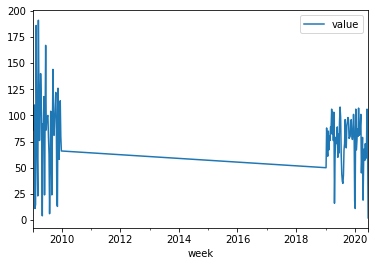

In [20]:
df1.plot() 

Increase the size and set Statistics Norway's green

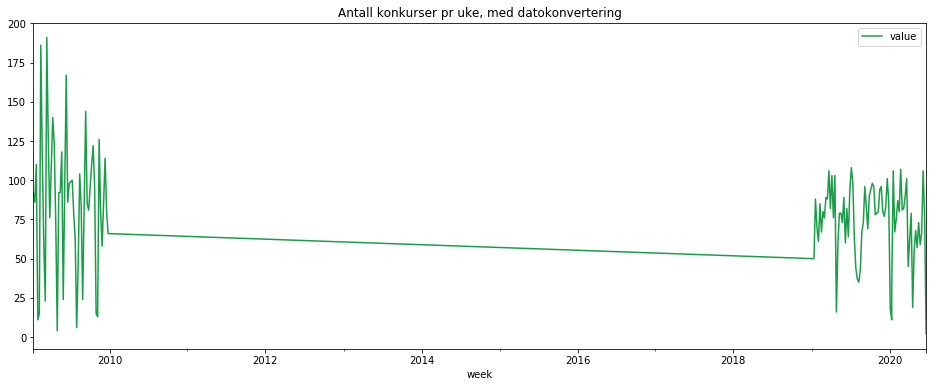

In [21]:
df1.plot(figsize=(16, 6), color='#1a9d49', title="Number of bankruptcies per week, with date conversion")